In [1]:
def sample_data(n, t_min, t_max, p_min, p_max, w_min, w_max):
    patients = list(range(n))
    a = np.random.randint(t_min, t_max, size=n)
    p = np.random.randint(p_min, p_max, size=n)
    w = np.random.randint(w_min, w_max, size=n)  # urgency levels
    d = [15 * w[i] for i in range(n)]  # due dates based on urgency levels
    s = [0 for _ in patients]
    value = [0 for _ in patients]
    return pd.DataFrame({"a": a, "p": p, "d": d, "w": w, "s": s, "value": value})

In [2]:
def sample(t,h):
  n = 3 #number of fictive jobs
  j = list(range(n))
  p=[np.random.randint(t,t+h) for i in j]
  r = [np.random.randint(t,t+h) for i in j]
  d = [np.random.randint(max(t,40),max(t+h,90)) for i in j]
  #flag for if job is processed or no.
  s=[0 for j in j]
  #value of having the job as the next one
  value = [0 for j in j]
  #dataframe with scenario
  A=pd.DataFrame({"r":r,"p":p,"d":d,"s":s,"value":value})
  return A

In [3]:
def choosePatientEA1(cm, sol, J):
    if J.empty:
        return None

    best_job = None
    best_value = float('inf')

    for j in J.index:
        temp_jobs = J.copy()
        temp_jobs['value'] = 0
        temp_jobs.at[j, 'value'] = -1  # selecting this patient first

        jobs = pd.concat([temp_jobs]).fillna(0)
        jb = [j]  # sequence with j as the first patient
        jobs.at[j, 'value'] = -1  # this patient can't be scheduled again

        while len(jobs[jobs['value'] == 0].index) > 0:
            next_patient = jobs[jobs['value'] == 0]['a'].idxmin()
            jb.append(next_patient)
            jobs.at[next_patient, 'value'] = -1

        current_value = objective(cm, jb, jobs)
        if current_value < best_value:
            best_value = current_value
            best_job = j

    return best_job


In [4]:
# now lets create a algorithm where we call the algorithm heuratically.

In [5]:
#largest val total earliness
def choosePatientEA3(cm, sol, J):
    nA = 3
    A = []
    h = 15
    for s in range(nA):
        A.append(sample_data(len(J), 0, h, 5, 15, 1, 4))  # Generate fictive patients data
    # iterate over the scenarios
    for s in range(nA):
        for j in J.index: # calculate the importance of job j as the first in scenario as
            # dataframe with all available jobs at the time j: real and fictive
            jobs = pd.concat([J, A[s]], keys=['J', 'A']).fillna(0)
            # sequence of jobs-solution of scenario A[s] where j is the first job
            nj = ('J', j) # this is the first job of j to be processed
            jb = list(jobs.index) # is the first job
            # save the best sequence
            bestjb = []
            bestvalue = -1

            # scheduling the other jobs with the optimization alg
            for i in range(500):
                jb.remove(nj)
                rd.shuffle(jb)
                jb.insert(0, nj)
                value = objective(cm, jb, jobs)
                if value > bestvalue:
                    bestvalue = value
                    bestjb = cp.deepcopy(jb)
            # update job value
            J.at[j, 'value'] += objective(cm, bestjb, jobs)
    bj = J['value'].idxmax()
    return bj


In [6]:
#largest val processing time 
def choosePatientEA2(cm, sol, J):
    nA = 3
    A = []
    h = 15
    for s in range(nA):
        A.append(sample_data(len(J), 0, h, 5, 15, 1, 4))  # Generate fictive patients data

    for s in range(nA):
        for j in J.index:  # calculate the importance of job j as the first in scenario as
            # dataframe with all available jobs at the time j: real and fictive
            jobs = pd.concat([J, A[s]], keys=['J', 'A']).fillna(0)
            # sequence of jobs-solution of scenario A[s] where j is the first job
            nj = ('J', j)  # this is the first job of j to be processed
            jb = [nj]  # is the first job
            jobs.at[nj, 's'] = -1  # this job can't be scheduled again
            
            # scheduling the other jobs with the optimization alg
            while len(jobs[jobs['s'] == 0].index) > 0:
                i = jobs[jobs['s'] == 0]['p'].idxmax()
                jb.append(i)
                jobs.at[i, 's'] = -1  # Modify using .at to avoid SettingWithCopyWarning
                
            # the sequence of jobs in jb
            J.at[j, 'value'] += objective(cm, jb, jobs)
    
    bj = J['value'].idxmax()
    return bj


In [7]:
def choosePatientCA1(cm, sol, J):
    nA = 3
    A = []
    h = 15
    
    for s in range(nA):
        A.append(sample_data(len(J), 0, h, 5, 15, 1, 4))
    
    for s in range(nA):
        # Concatenate J and A[s], filling NaN values with 0
        jobs = pd.concat([J, A[s]], keys=['J', 'A']).fillna(0)
        jb = []
        
        while len(jobs[jobs['s'] == 0].index) > 0:
            i = jobs[jobs['s'] == 0]['a'].idxmin()
            jb.append(i)
            # Modify jobs DataFrame using .at to avoid SettingWithCopyWarning
            jobs.at[i, 's'] = -1
        
        nj = jb[0]
        k = nj[0]
        j = nj[1]
        
        if k == 'J':
            J.at[j, 'value'] += objective(cm, jb, jobs) + 1
        else:
            print('The first job is not a real job:', nj)
    
    bj = J['value'].idxmax()
    return bj



In [8]:
def choosePatientCA2(cm, sol, J):
    nA = 3
    A = []
    h = 15
    
    for s in range(nA):
        A.append(sample_data(len(J), 0, h, 5, 15, 1, 4))
    
    for s in range(nA):
        # Concatenate J and A[s], filling NaN values with 0
        jobs = pd.concat([J, A[s]], keys=['J', 'A']).fillna(0)
        jb = []
        
        while len(jobs[jobs['s'] == 0].index) > 0:
            i = jobs[jobs['s'] == 0]['p'].idxmin()
            jb.append(i)
            # Modify jobs DataFrame using .at to avoid SettingWithCopyWarning
            jobs.at[i, 's'] = -1
        
        nj = jb[0]
        k = nj[0]
        j = nj[1]
        
        if k == 'J':
            J.at[j, 'value'] += objective(cm, jb, jobs) + 1
        else:
            print('The first job is not a real job:', nj)
    
    bj = J['value'].idxmax()
    return bj


In [9]:
def choosePatientCA3(cm, sol, J):
    nA = 3
    A = []
    h = 15
    
    # Generate fictive patients data for each scenario
    for s in range(nA):
        A.append(sample_data(len(J), 0, h, 5, 15, 1, 4))
    
    # Iterate over the scenarios
    for s in range(nA):
        jobs = pd.concat([J, A[s]], keys=['J', 'A']).fillna(0)
        jb = list(jobs.index)
        
        # Save the best sequence
        bestjb = []
        bestvalue = -1  # maximize
        
        # Generate random sequences and find the best one
        for i in range(100):
            rd.shuffle(jb)
            value = objective(cm, jb, jobs)
            if value > bestvalue:
                bestvalue = value
                bestjb = cp.deepcopy(jb)
        
        # Sequence of jobs in bestjb
        k = bestjb[0][0]  # key associated with the job
        j = bestjb[0][1]  # id of job
        
        if k == 'J':
            J.loc[j, 'value'] += objective(cm, bestjb, jobs) + 1
        else:
            print('The first job is not a real job', jb[0])
    
    bj = J['value'].idxmax()
    return bj

      a    p   d  w  s  value
0   172  194  60  4  0    0.0
1    47   40  15  1  0    0.0
2   117   88  45  3  0    0.0
3   192  175  60  4  0    0.0
4    67   89  15  1  0    0.0
5   195   82  30  2  0    0.0
6   103  166  60  4  0    0.0
7     9   26  30  2  0    0.0
8    21   78  60  4  0    0.0
9    36   73  60  4  0    0.0
10   87   10  45  3  0    0.0
11   70  149  60  4  0    0.0
12   88  116  15  1  0    0.0
13  140  198  30  2  0    0.0
14   58   80  30  2  0    0.0

 Sequence:  [7.0, 8.0, 12.0, 13.0, 3.0, 4.0, 6.0, 5.0, 0.0]

 Starting time of patients:  [9.0, 35.0, 113.0, 229.0, 427.0, 602.0, 691.0, 857.0, 939.0]

 Completion time of patients:  [35.0, 113.0, 229.0, 427.0, 602.0, 691.0, 857.0, 939.0, 1133.0]

 Tardiness of patients:  [0.0, 0.0, 98.0, 199.0, 367.0, 587.0, 631.0, 827.0, 879.0]

 Weighted Tardiness of patients:  [0.0, 0.0, 98.0, 398.0, 1468.0, 587.0, 2524.0, 1654.0, 3516.0]

 Objective function (Total Weighted Tardiness):  10245.0
      a    p   d  w  s  value
0

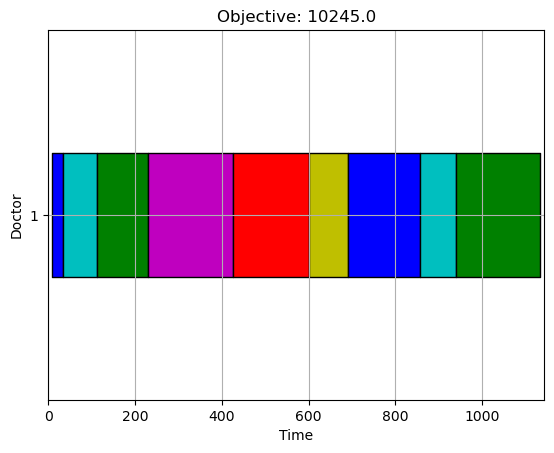

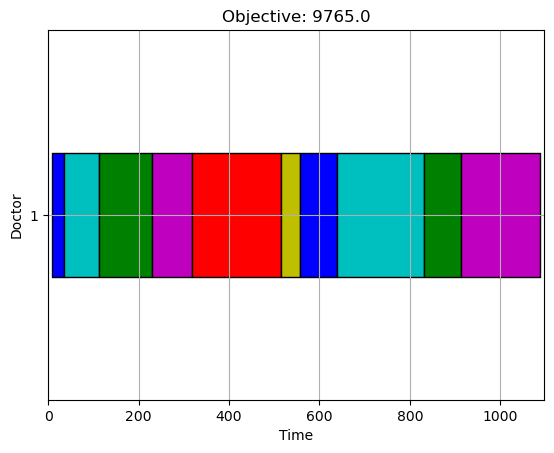

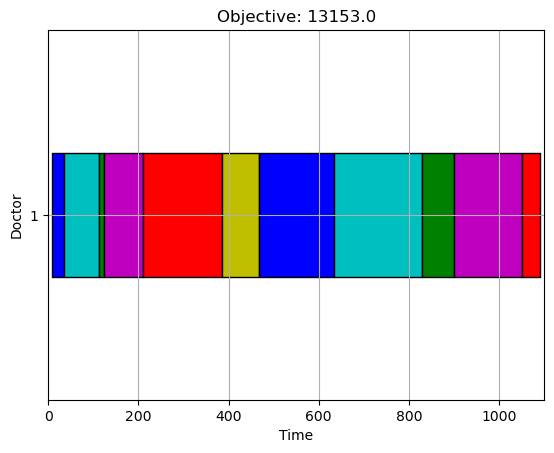

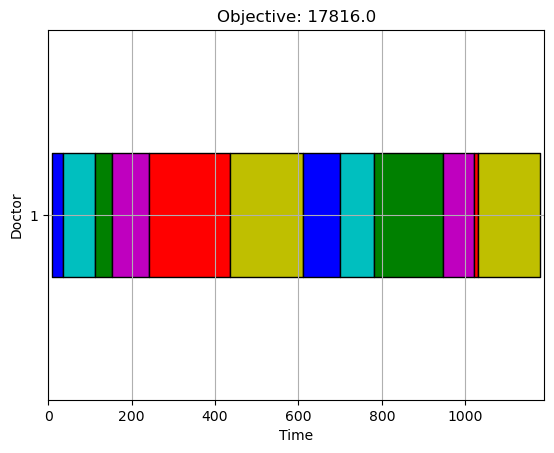

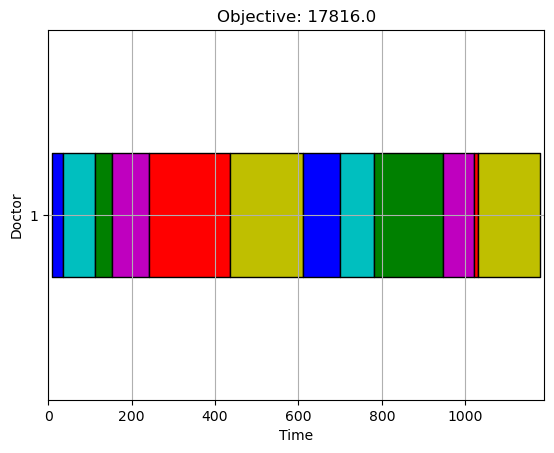

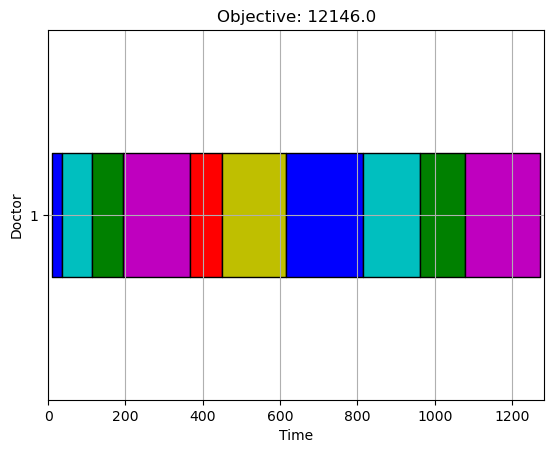

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import random as rd
import copy as cp
import numpy as np

def printSol(patients, obj, name):
    fig, gnt = plt.subplots()
    # axis limits
    gnt.set_ylim(0, 30)
    gnt.set_xlim(0, max(patients.C) + 10)
    # labels and title
    gnt.set_xlabel('Time')
    gnt.set_ylabel('Doctor')
    plt.title(f"Objective: {obj}")
    # set ticks
    gnt.set_yticks([15])
    gnt.set_yticklabels(['1'])
    gnt.grid(True)

    # plot the jobs
    lcolor = ['b', 'c', 'g', 'm', 'r', 'y', 'b', 'c', 'g', 'm', 'r', 'y']
    for i in patients.index:
        gnt.broken_barh([(patients.I.loc[i], patients.C.loc[i] - patients.I.loc[i])], (10, 10),
                        facecolors=lcolor[i % len(lcolor)], edgecolor='k')

    plt.savefig(name + ".png")

def objective(cm, jb, jobs):
    S=[] # sequence
    I=[] # starting time
    C=[] # completion time
    T=[] # tardiness
    WT=[] # weighted tardiness
    t = cm # current time of machine

    for i in jb:
        S.append(i) # next patient
        st = max(t, jobs['a'].loc[i])
        I.append(st)

        ct = st + jobs['p'].loc[i]
        C.append(ct) # completion time of patient

        tard = max(0, st - jobs['d'].loc[i])
        T.append(tard)  # tardiness time
        wtard = jobs['w'].loc[i] * tard
        WT.append(wtard)  # weighted tardiness

        t = ct # after completion of job i
    # return the obj associated with jb
    return sum(WT)

def sample_data(n, t_min, t_max, p_min, p_max, w_min, w_max):
    np.random.seed(0)  # For reproducibility
    
    a= np.random.randint(t_min, t_max, n)
    p= np.random.randint(p_min, p_max, n)
    w= np.random.randint(w_min, w_max+1, n)
    d= w*15
    s= [0] * n  # status: 0 means job is not yet processed
    value= [0.0] * n

    data = {
        'a': a,
        'p': p,
        'd': d,
        'w': w,
        's': s,
        'value': value
    }
    return pd.DataFrame(data)


def run_reoptimization_simulation(algorithm, n=15, t_horizon=1080, t_min=0, t_max=200, p_min=1, p_max=200, w_min=1, w_max=4):
    patients_df = sample_data(n, t_min, t_max, p_min, p_max, w_min, w_max)
    print(patients_df)
    sol = pd.DataFrame({"S": [], "I": [], "C": [], "T": [], "WT": []})
    current_time = 0

    while current_time < t_horizon:
        # Check for new arrivals and doctor availability
        J = patients_df[(patients_df['a'] <= current_time) & (patients_df['s'] == 0)]
        cm = max(current_time, sol['C'].max()) if not sol.empty else current_time

        if cm > current_time or len(J) <= 0:
            current_time += 1
            continue

        # Invoke the heuristic to get the next job
        nj = algorithm(cm, sol, J)
        if nj is None:
            current_time += 1
            continue

        # Update the solution with the next job
        S = nj
        I = max(current_time, J['a'].loc[nj])  # starting time of patient
        C = I + patients_df['p'].loc[nj]  # completion time of patient
        T = max(0, I - patients_df['d'].loc[nj])  # tardiness of patient
        WT = patients_df['w'].loc[nj] * T  # weighted tardiness
        # new addition
        new = pd.DataFrame({"S": [S], "I": [I], "C": [C], "T": [T], "WT": [WT]})
        sol = pd.concat([sol, new], ignore_index=True)

        # Remove the job from the list of available jobs
        patients_df.at[nj, 's'] = -1
        current_time = C  # Advance current time to the completion of the current job

    # Print the obtained solution - total earliness
    obj = sum(sol['WT'])

    print("\n Sequence: ", sol["S"].tolist())
    print("\n Starting time of patients: ", sol["I"].tolist())
    print("\n Completion time of patients: ", sol["C"].tolist())
    print("\n Tardiness of patients: ", sol["T"].tolist())
    print("\n Weighted Tardiness of patients: ", sol["WT"].tolist())
    print("\n Objective function (Total Weighted Tardiness): ", obj)

    printSol(sol, obj, "doctor_schedule")

# Running the re-optimization simulation
run_reoptimization_simulation(choosePatientEA3)
run_reoptimization_simulation(choosePatientEA2)
run_reoptimization_simulation(choosePatientEA1)
run_reoptimization_simulation(choosePatientCA1)
run_reoptimization_simulation(choosePatientCA2)
run_reoptimization_simulation(choosePatientCA3)

# by our simulation we see that EA3 and EA2 give the best results


Results for Consensus Algorithm from Different Samples:

 Sequence:  [7.0, 8.0, 5.0, 3.0, 4.0, 2.0, 0.0, 6.0, 1.0, 9.0]

 Starting time of patients:  [9.0, 96.0, 326.0, 405.2, 635.4, 688.2, 717.8, 726.4, 875.0, 945.0]

 Completion time of patients:  [96.0, 270.0, 519.0, 545.2, 693.4, 776.2, 804.8, 765.4, 945.0, 1033.0]

 Tardiness of patients:  [0.0, 81.0, 296.0, 375.2, 620.4, 658.2, 687.8, 711.4, 845.0, 885.0]

 Weighted Tardiness of patients:  [0.0, 81.0, 592.0, 750.4, 620.4, 1316.4, 1375.6, 711.4, 1690.0, 3540.0]

 Objective function (Total Weighted Tardiness):  10677.2

 Sequence:  [7.0, 4.0, 8.0, 5.0, 0.0, 6.0, 3.0, 1.0, 2.0, 9.0]

 Starting time of patients:  [9.0, 96.0, 154.0, 328.0, 521.0, 608.0, 647.0, 787.0, 857.0, 945.0]

 Completion time of patients:  [96.0, 154.0, 328.0, 521.0, 608.0, 647.0, 787.0, 857.0, 945.0, 1033.0]

 Tardiness of patients:  [0.0, 81.0, 139.0, 298.0, 491.0, 593.0, 617.0, 757.0, 827.0, 885.0]

 Weighted Tardiness of patients:  [0.0, 81.0, 139.0, 596.0,

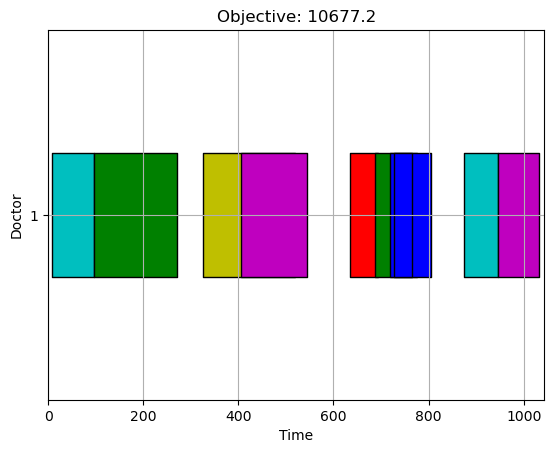

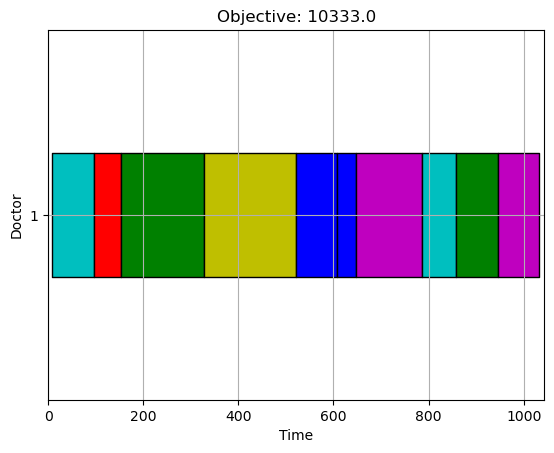

In [31]:
#create and run your algorithm on different samples
def run_simulation_for_sample(algorithm,patients_df, n=10, t_horizon=1080):
    sol = pd.DataFrame({"S": [], "I": [], "C": [], "T": [], "WT": []})
    H = t_horizon  # duration of time horizon

    current_time = 0
    while current_time < H:
        J = patients_df[(patients_df['a'] <= current_time) & (patients_df['s'] == 0)]
        cm = max(current_time, sol['C'].max()) if not sol.empty else current_time
        if cm > current_time or len(J) <= 0:
            current_time += 1
            continue
        nj = algorithm(cm, sol, J)
        if nj is None:
            current_time += 1
            continue
        S = nj
        I = max(current_time, J['a'].loc[nj])
        C = I + patients_df['p'].loc[nj]
        T = max(0, I - patients_df['d'].loc[nj])
        WT = patients_df['w'].loc[nj] * T
        new = pd.DataFrame({"S": [S], "I": [I], "C": [C], "T": [T], "WT": [WT]})
        sol = pd.concat([sol, new], ignore_index=True)
        patients_df.at[nj, 's'] = -1
        current_time = C
    
    return sol

def consensusAlgorithmFromSamples(algorithm,samples, t_horizon=1080):
    all_solutions = []
    for sample_df in samples:
        sol = run_simulation_for_sample(algorithm,sample_df, t_horizon=t_horizon)
        all_solutions.append(sol)

    consensus_sol = pd.concat(all_solutions).groupby('S').mean().reset_index()
    consensus_sol = consensus_sol.sort_values(by='I')
    consensus_obj = consensus_sol['WT'].sum()

    return consensus_sol, consensus_obj

def run_consensus_simulation(algorithm,num_samples=5, n=10, t_horizon=1080, t_min=0, t_max=200, p_min=0, p_max=200, w_min=1, w_max=4):
    samples = [sample_data(n, t_min, t_max, p_min, p_max, w_min, w_max) for _ in range(num_samples)]
    consensus_sol, consensus_obj = consensusAlgorithmFromSamples(algorithm,samples, t_horizon=t_horizon)

    print("\n Sequence: ", consensus_sol["S"].tolist())
    print("\n Starting time of patients: ", consensus_sol["I"].tolist())
    print("\n Completion time of patients: ", consensus_sol["C"].tolist())
    print("\n Tardiness of patients: ", consensus_sol["T"].tolist())
    print("\n Weighted Tardiness of patients: ", consensus_sol["WT"].tolist())
    print("\n Objective function (Total Weighted Tardiness): ", consensus_obj)

    printSol(consensus_sol, consensus_obj, "doctor_schedule")

# Run the consensus simulation
print("\nResults for Consensus Algorithm from Different Samples:")

run_consensus_simulation(choosePatientEA3)
run_consensus_simulation(choosePatientEA2)

     a    p   d  w  s  value
0  172  196  60  4  0    0.0
1   47  104  45  3  0    0.0
2  117   10  15  1  0    0.0
3  192   22  15  1  0    0.0
4   67   37  15  1  0    0.0

 Sequence:  [1.0, 4.0, 0.0, 3.0, 2.0]

 Starting time of patients:  [47.0, 151.0, 188.0, 384.0, 406.0]

 Completion time of patients:  [151.0, 188.0, 384.0, 406.0, 416.0]

 Tardiness of patients:  [2.0, 136.0, 128.0, 369.0, 391.0]

 Weighted Tardiness of patients:  [6.0, 136.0, 512.0, 369.0, 391.0]

 Objective function (Total Weighted Tardiness):  1414.0
     a    p   d  w  s  value
0  172  196  60  4  0    0.0
1   47  104  45  3  0    0.0
2  117   10  15  1  0    0.0
3  192   22  15  1  0    0.0
4   67   37  15  1  0    0.0

 Sequence:  [1.0, 4.0, 0.0, 3.0, 2.0]

 Starting time of patients:  [47.0, 151.0, 188.0, 384.0, 406.0]

 Completion time of patients:  [151.0, 188.0, 384.0, 406.0, 416.0]

 Tardiness of patients:  [2.0, 136.0, 128.0, 369.0, 391.0]

 Weighted Tardiness of patients:  [6.0, 136.0, 512.0, 369.0, 

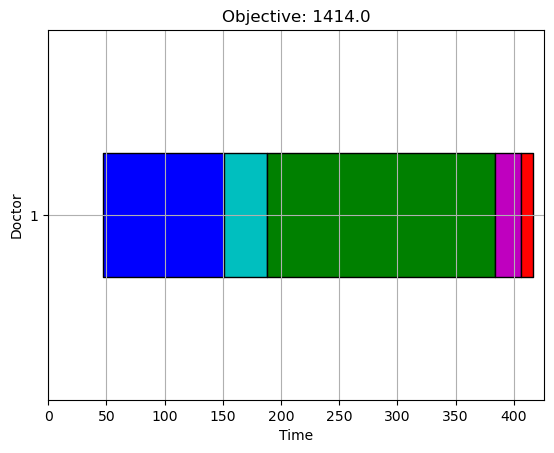

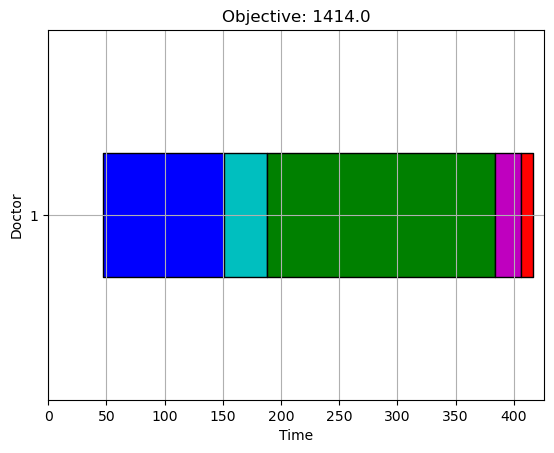

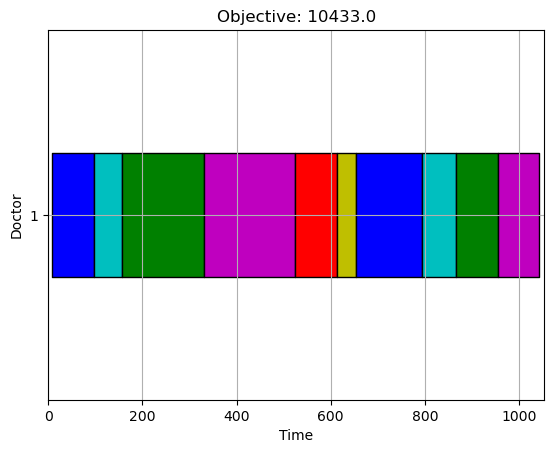

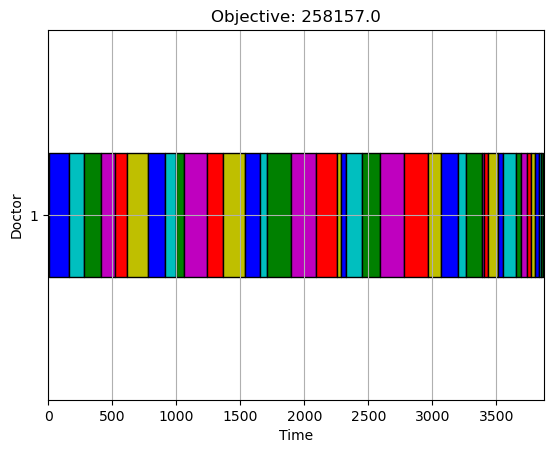

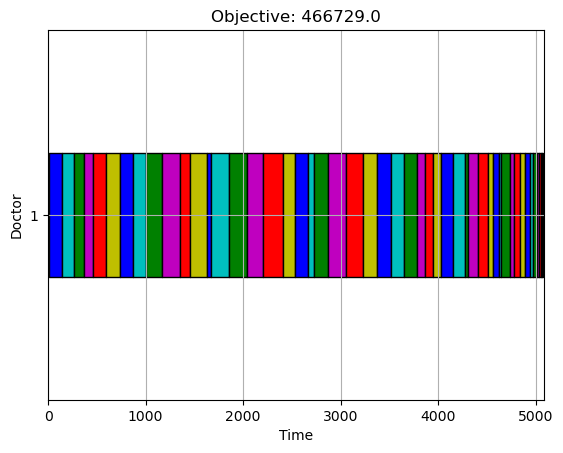

In [33]:
def sample_data_random(n, t_min, t_max, p_min, p_max, w_min, w_max):
    #no seed for real random outputs
    
    a= np.random.randint(t_min, t_max, n)
    p= np.random.randint(p_min, p_max, n)
    w= np.random.randint(w_min, w_max+1, n)
    d= w*15
    s= [0] * n  # status: 0 means job is not yet processed
    value= [0.0] * n

    data = {
        'a': a,
        'p': p,
        'd': d,
        'w': w,
        's': s,
        'value': value
    }
    return pd.DataFrame(data)


def run_reoptimization_simulation2(algorithm, n, t_horizon=9980, t_min=0, t_max=200, p_min=1, p_max=200, w_min=1, w_max=4):
    patients_df = sample_data(n, t_min, t_max, p_min, p_max, w_min, w_max)
    print(patients_df)
    sol = pd.DataFrame({"S": [], "I": [], "C": [], "T": [], "WT": []})
    current_time = 0

    while current_time < t_horizon:
        # Check for new arrivals and doctor availability
        J = patients_df[(patients_df['a'] <= current_time) & (patients_df['s'] == 0)]
        cm = max(current_time, sol['C'].max()) if not sol.empty else current_time

        if cm > current_time or len(J) <= 0:
            current_time += 1
            continue

        # Invoke the heuristic to get the next job
        nj = algorithm(cm, sol, J)
        if nj is None:
            current_time += 1
            continue

        # Update the solution with the next job
        S = nj
        I = max(current_time, J['a'].loc[nj])  # starting time of patient
        C = I + patients_df['p'].loc[nj]  # completion time of patient
        T = max(0, I - patients_df['d'].loc[nj])  # tardiness of patient
        WT = patients_df['w'].loc[nj] * T  # weighted tardiness
        # new addition
        new = pd.DataFrame({"S": [S], "I": [I], "C": [C], "T": [T], "WT": [WT]})
        sol = pd.concat([sol, new], ignore_index=True)

        # Remove the job from the list of available jobs
        patients_df.at[nj, 's'] = -1
        current_time = C  # Advance current time to the completion of the current job

    # Print the obtained solution - total earliness
    obj = sum(sol['WT'])

    print("\n Sequence: ", sol["S"].tolist())
    print("\n Starting time of patients: ", sol["I"].tolist())
    print("\n Completion time of patients: ", sol["C"].tolist())
    print("\n Tardiness of patients: ", sol["T"].tolist())
    print("\n Weighted Tardiness of patients: ", sol["WT"].tolist())
    print("\n Objective function (Total Weighted Tardiness): ", obj)

    printSol(sol, obj, "doctor_schedule")

run_reoptimization_simulation2(choosePatientEA2,5)
run_reoptimization_simulation2(choosePatientEA2,5)
run_reoptimization_simulation2(choosePatientEA2,10)
run_reoptimization_simulation2(choosePatientEA2,40)
run_reoptimization_simulation2(choosePatientEA2,50)


     p    a  w  s   d  value
0   27    9  2  0  30    0.0
1   22   21  3  0  45    0.0
2   11   12  2  0  30    0.0
3   12    8  3  0  45    0.0
4   46   24  3  0  45    0.0
5   28   38  3  0  45    0.0
6   17   44  3  0  45    0.0
7   34   54  2  0  30    0.0
8    6   61  2  0  30    0.0
9    2   64  2  0  30    0.0
10  16  114  2  0  30    0.0
11  22  106  2  0  30    0.0
12   7   81  2  0  30    0.0
13  11  103  2  0  30    0.0
14  18   82  1  0  15    0.0
15  18   88  3  0  45    0.0
16  11   70  2  0  30    0.0
17   3   71  3  0  45    0.0
18   2   84  2  0  30    0.0
19   6   84  2  0  30    0.0
20   6   95  1  0  15    0.0
21  11  155  1  0  15    0.0
22  18  140  3  0  45    0.0
23  19  145  2  0  30    0.0
24  16  150  2  0  30    0.0
25  25  169  3  0  45    0.0
26   7  144  2  0  30    0.0
27  11  175  1  0  15    0.0
28  12  158  2  0  30    0.0
29   7  175  1  0  15    0.0
30  13  153  4  0  60    0.0
31  26  157  2  0  30    0.0
32  23  177  2  0  30    0.0
33  16  140  2

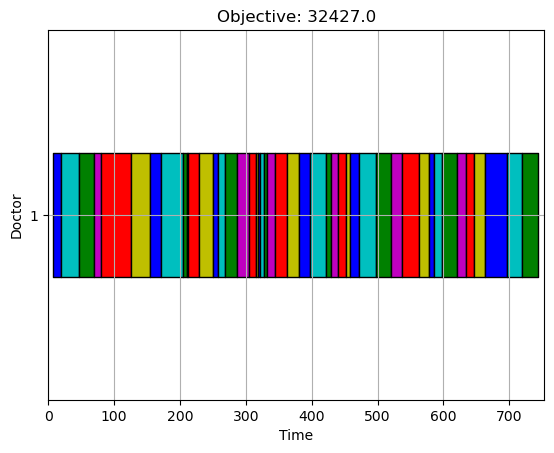

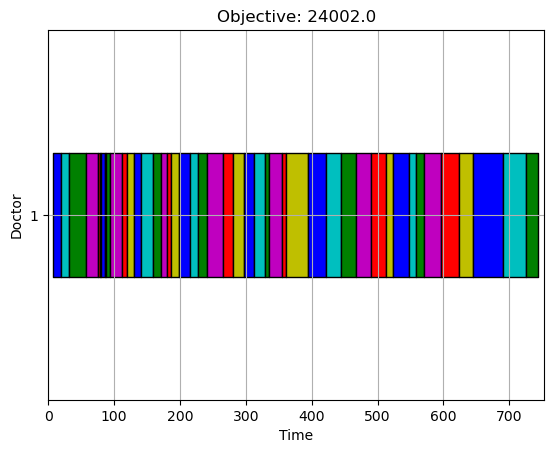

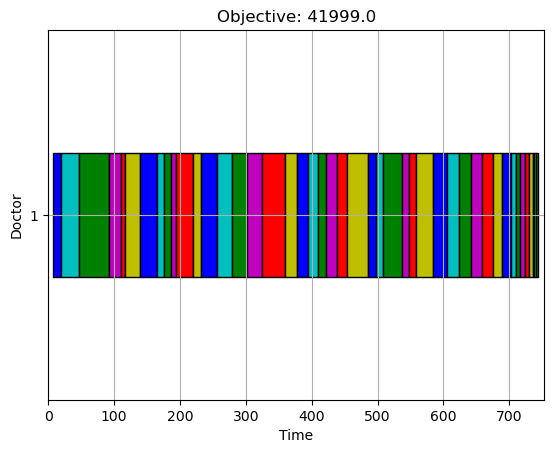

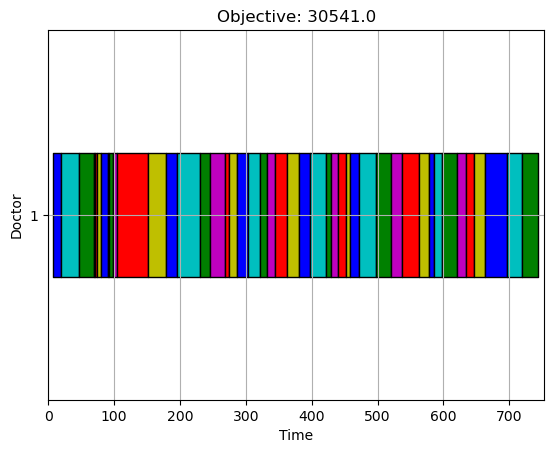

In [18]:
import os
notebook_path = os.path.abspath("Notebook.ipynb")
def open_and_parse(txt):
    file_path = os.path.join(os.path.dirname(notebook_path), txt)
    ids = []
    p_values = []
    a_values = []
    w_values = []

    # Read the file line by line
    with open(file_path, 'r') as file:
        # Skip first 7 lines
        next(file)  
        next(file)  
        next(file)  
        next(file)  
        next(file)  
        next(file)  
        next(file)  
        # Read remaining lines
        for line in file:
            # Split line by whitespace and extract values
            values = line.strip().split()

            # Convert values to appropriate data types
            id_val = int(values[0])
            p_val = int(values[1])
            a_val = int(values[2])
            w_val = int(values[3])
            
            # Append values to lists
            ids.append(id_val)
            p_values.append(p_val)
            a_values.append(a_val)
            w_values.append(w_val)
            d_values = [w_val * 15 for w_val in w_values]
            s_values = [0] * len(p_values)
            value= [0.0] * len(p_values)

    # Create DataFrame from collected data
    patients_df = pd.DataFrame({
        'p': p_values,
        'a': a_values,
        'w': w_values,
        's': s_values,
        'd': d_values,
        'value':value,
    })
    
    return patients_df

def run_reoptimization(algorithm,txt_giv,t_horizon=1080):
        
    # Print the content to verify
    patients_df=open_and_parse(txt_giv)
    print(patients_df)
    sol = pd.DataFrame({"S": [], "I": [], "C": [], "T": [], "WT": []})
    current_time = 0

    while current_time < t_horizon:
        # Check for new arrivals and doctor availability
        J = patients_df[(patients_df['a'] <= current_time) & (patients_df['s'] == 0)]
        cm = max(current_time, sol['C'].max()) if not sol.empty else current_time

        if cm > current_time or len(J) <= 0:
            current_time += 1
            continue

        # Invoke the heuristic to get the next job
        nj = algorithm(cm, sol, J)
        if nj is None:
            current_time += 1
            continue

        # Update the solution with the next job
        S = nj
        I = max(current_time, J['a'].loc[nj])  # starting time of patient
        C = I + patients_df['p'].loc[nj]  # completion time of patient
        T = max(0, I - patients_df['d'].loc[nj])  # tardiness of patient
        WT = patients_df['w'].loc[nj] * T  # weighted tardiness
        # new addition
        new = pd.DataFrame({"S": [S], "I": [I], "C": [C], "T": [T], "WT": [WT]})
        sol = pd.concat([sol, new], ignore_index=True)

        # Remove the job from the list of available jobs
        patients_df.at[nj, 's'] = -1
        current_time = C  # Advance current time to the completion of the current job

    # Print the obtained solution - total earliness
    obj = sum(sol['WT'])

    print("\n Sequence: ", sol["S"].tolist())
    print("\n Starting time of patients: ", sol["I"].tolist())
    print("\n Completion time of patients: ", sol["C"].tolist())
    print("\n Tardiness of patients: ", sol["T"].tolist())
    print("\n Weighted Tardiness of patients: ", sol["WT"].tolist())
    print("\n Objective function (Total Weighted Tardiness): ", obj)

    printSol(sol, obj, "doctor_schedule")

# Running the re-optimization simulation

run_reoptimization(choosePatientCA1,"instance1.txt")
run_reoptimization(choosePatientEA1,"instance1.txt")
run_reoptimization(choosePatientEA2,"instance1.txt")
run_reoptimization(choosePatientCA2,"instance1.txt")



     p    a  w  s   d  value
0   27    9  2  0  30    0.0
1   22   21  3  0  45    0.0
2   11   12  2  0  30    0.0
3   12    8  3  0  45    0.0
4   46   24  3  0  45    0.0
5   28   38  3  0  45    0.0
6   17   44  3  0  45    0.0
7   34   54  2  0  30    0.0
8    6   61  2  0  30    0.0
9    2   64  2  0  30    0.0
10  16  114  2  0  30    0.0
11  22  106  2  0  30    0.0
12   7   81  2  0  30    0.0
13  11  103  2  0  30    0.0
14  18   82  1  0  15    0.0
15  18   88  3  0  45    0.0
16  11   70  2  0  30    0.0
17   3   71  3  0  45    0.0
18   2   84  2  0  30    0.0
19   6   84  2  0  30    0.0
20   6   95  1  0  15    0.0
21  11  155  1  0  15    0.0
22  18  140  3  0  45    0.0
23  19  145  2  0  30    0.0
24  16  150  2  0  30    0.0
25  25  169  3  0  45    0.0
26   7  144  2  0  30    0.0
27  11  175  1  0  15    0.0
28  12  158  2  0  30    0.0
29   7  175  1  0  15    0.0
30  13  153  4  0  60    0.0
31  26  157  2  0  30    0.0
32  23  177  2  0  30    0.0
33  16  140  2

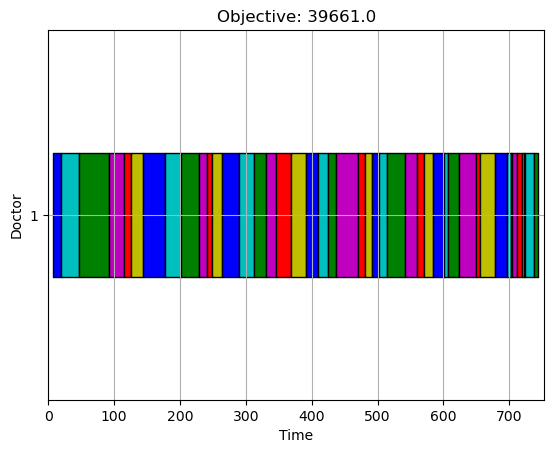

In [20]:
run_reoptimization(choosePatientCA3,"instance1.txt")

In [ ]:
run_reoptimization(choosePatientEA3,"instance1.txt")

     p    a  w  s   d  value
0   27    9  2  0  30    0.0
1   22   21  3  0  45    0.0
2   11   12  2  0  30    0.0
3   12    8  3  0  45    0.0
4   46   24  3  0  45    0.0
5   28   38  3  0  45    0.0
6   17   44  3  0  45    0.0
7   34   54  2  0  30    0.0
8    6   61  2  0  30    0.0
9    2   64  2  0  30    0.0
10  16  114  2  0  30    0.0
11  22  106  2  0  30    0.0
12   7   81  2  0  30    0.0
13  11  103  2  0  30    0.0
14  18   82  1  0  15    0.0
15  18   88  3  0  45    0.0
16  11   70  2  0  30    0.0
17   3   71  3  0  45    0.0
18   2   84  2  0  30    0.0
19   6   84  2  0  30    0.0
20   6   95  1  0  15    0.0
21  11  155  1  0  15    0.0
22  18  140  3  0  45    0.0
23  19  145  2  0  30    0.0
24  16  150  2  0  30    0.0
25  25  169  3  0  45    0.0
26   7  144  2  0  30    0.0
27  11  175  1  0  15    0.0
28  12  158  2  0  30    0.0
29   7  175  1  0  15    0.0
30  13  153  4  0  60    0.0
31  26  157  2  0  30    0.0
32  23  177  2  0  30    0.0
33  16  140  2

     p    a  w  s   d  value
0   16   24  2  0  30    0.0
1   21   18  2  0  30    0.0
2   26    6  3  0  45    0.0
3   13    8  3  0  45    0.0
4    4   46  2  0  30    0.0
5   28    4  3  0  45    0.0
6   11   20  3  0  45    0.0
7    3   93  4  0  60    0.0
8    7   96  1  0  15    0.0
9   10  101  4  0  60    0.0
10  33  118  3  0  45    0.0
11  34  108  3  0  45    0.0
12   6   98  1  0  15    0.0
13  14   66  1  0  15    0.0
14  31   85  2  0  30    0.0
15  21   78  2  0  30    0.0
16  13  167  1  0  15    0.0
17  20  131  3  0  45    0.0
18   6  178  4  0  60    0.0
19  23  121  1  0  15    0.0
20  25  170  2  0  30    0.0
21  12  123  1  0  15    0.0
22  28  151  3  0  45    0.0
23  12  177  4  0  60    0.0
24  22  205  4  0  60    0.0
25   9  196  1  0  15    0.0
26  31  199  3  0  45    0.0
27   9  196  1  0  15    0.0

 Sequence:  [5.0, 2.0, 1.0, 13.0, 14.0, 21.0, 19.0, 8.0, 11.0, 25.0, 27.0, 16.0, 12.0, 20.0, 15.0, 10.0, 0.0, 26.0, 22.0, 17.0, 24.0, 3.0, 6.0, 23.0, 4.0, 9.0

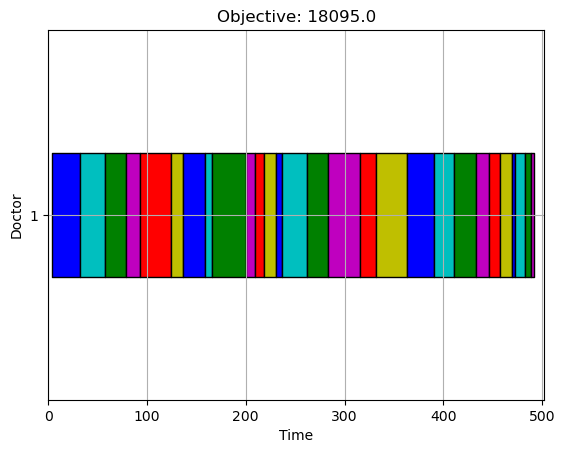

In [26]:
run_reoptimization(choosePatientEA2,"instance2.txt")

     p    a  w  s   d  value
0   16   55  2  0  30    0.0
1    5   38  2  0  30    0.0
2   35   50  4  0  60    0.0
3   23   10  1  0  15    0.0
4    5   22  2  0  30    0.0
5   26    2  3  0  45    0.0
6    7   58  3  0  45    0.0
7   24    1  3  0  45    0.0
8   15    3  2  0  30    0.0
9   11   21  3  0  45    0.0
10  20   50  2  0  30    0.0
11  19   16  2  0  30    0.0
12  10  111  1  0  15    0.0
13  19   89  3  0  45    0.0
14  33   82  2  0  30    0.0
15  44  105  2  0  30    0.0
16   7  112  2  0  30    0.0
17  15  107  3  0  45    0.0
18   8   79  2  0  30    0.0
19  23  136  1  0  15    0.0
20  13  159  3  0  45    0.0
21  15  179  2  0  30    0.0
22  16  176  3  0  45    0.0
23  35  129  2  0  30    0.0
24  20  175  2  0  30    0.0
25  23  157  2  0  30    0.0
26   9  204  1  0  15    0.0
27  21  217  3  0  45    0.0
28  28  215  2  0  30    0.0
29  14  195  2  0  30    0.0
30  10  209  3  0  45    0.0
31  21  223  2  0  30    0.0
32   9  209  2  0  30    0.0

 Sequence:  [

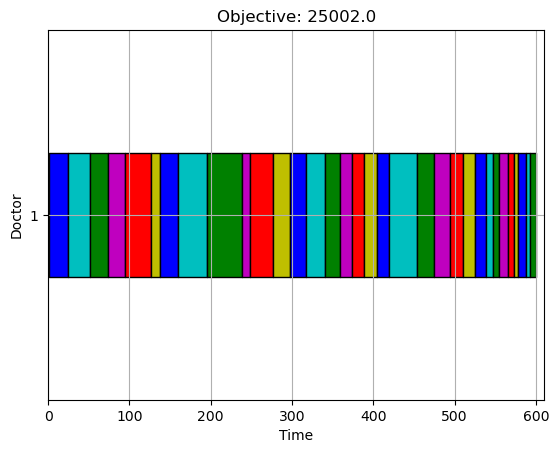

In [27]:
run_reoptimization(choosePatientEA2,"instance3.txt")

     p    a  w  s   d  value
0    5   47  3  0  45    0.0
1   20   13  2  0  30    0.0
2   20   52  3  0  45    0.0
3    8   58  2  0  30    0.0
4    9   26  2  0  30    0.0
5   28   42  2  0  30    0.0
6   24   28  3  0  45    0.0
7   15   28  2  0  30    0.0
8   19   17  2  0  30    0.0
9   25   21  2  0  30    0.0
10  14   19  2  0  30    0.0
11  24  114  2  0  30    0.0
12  18  109  1  0  15    0.0
13  18  107  3  0  45    0.0
14  21   77  2  0  30    0.0
15  19   80  4  0  60    0.0
16  16   73  2  0  30    0.0
17  10  117  2  0  30    0.0
18  41   99  3  0  45    0.0
19  23  114  3  0  45    0.0
20   7   60  2  0  30    0.0
21  15   64  3  0  45    0.0
22  24  106  2  0  30    0.0
23  22  122  2  0  30    0.0
24  11  127  2  0  30    0.0
25   8  161  3  0  45    0.0
26  20  162  3  0  45    0.0
27  12  140  2  0  30    0.0
28   9  141  1  0  15    0.0
29  14  174  2  0  30    0.0
30   9  156  2  0  30    0.0
31  15  176  3  0  45    0.0
32  23  239  3  0  45    0.0
33  11  214  1

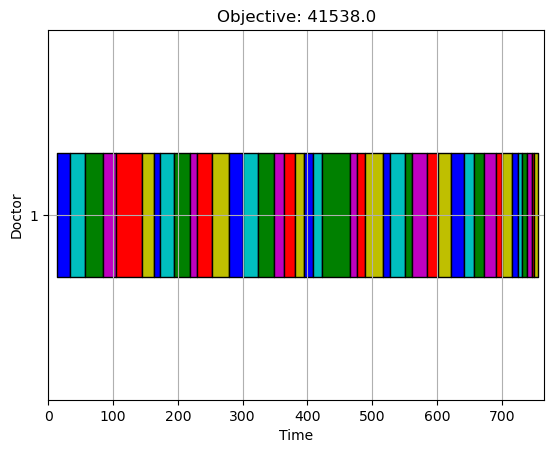

In [28]:
run_reoptimization(choosePatientEA2,"instance4.txt")

     p    a  w  s   d  value
0   12   37  2  0  30    0.0
1    5   16  3  0  45    0.0
2   11   48  2  0  30    0.0
3    1    0  1  0  15    0.0
4    2   55  2  0  30    0.0
5   19   67  1  0  15    0.0
6   18   62  4  0  60    0.0
7   11  108  2  0  30    0.0
8   24   69  2  0  30    0.0
9   21   86  3  0  45    0.0
10  38  113  4  0  60    0.0
11   2  109  3  0  45    0.0
12  21  108  3  0  45    0.0
13  19   66  2  0  30    0.0
14  14   73  2  0  30    0.0
15  10   77  1  0  15    0.0
16  39  123  2  0  30    0.0
17  21  122  3  0  45    0.0
18  16  124  3  0  45    0.0
19  21  132  2  0  30    0.0
20  18  140  2  0  30    0.0
21  10  148  3  0  45    0.0
22  12  159  2  0  30    0.0
23  22  176  1  0  15    0.0
24  22  173  4  0  60    0.0
25   6  128  1  0  15    0.0
26   6  177  1  0  15    0.0
27  41  204  3  0  45    0.0
28   9  233  2  0  30    0.0
29  16  233  2  0  30    0.0
30   9  218  1  0  15    0.0
31  14  210  3  0  45    0.0
32   9  193  2  0  30    0.0

 Sequence:  [

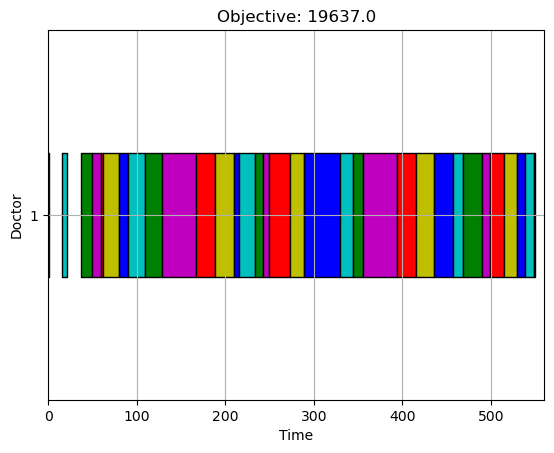

In [29]:
run_reoptimization(choosePatientEA2,"instance5.txt")

     p    a  w  s   d  value
0   10    0  1  0  15    0.0
1   11   55  3  0  45    0.0
2   20    8  3  0  45    0.0
3    6   41  2  0  30    0.0
4   13   59  2  0  30    0.0
5   14   39  1  0  15    0.0
6   12   58  2  0  30    0.0
7    8   27  2  0  30    0.0
8   30   51  3  0  45    0.0
9   26   31  4  0  60    0.0
10  20   17  3  0  45    0.0
11  28   31  2  0  30    0.0
12  11   30  2  0  30    0.0
13  10   56  3  0  45    0.0
14  14   11  1  0  15    0.0
15   1   60  2  0  30    0.0
16  17   90  2  0  30    0.0
17   6   90  4  0  60    0.0
18   5   68  1  0  15    0.0
19  18  108  3  0  45    0.0
20  18   78  2  0  30    0.0
21  16   62  2  0  30    0.0
22  19  139  3  0  45    0.0
23  34  129  1  0  15    0.0
24  17  144  2  0  30    0.0
25  21  163  2  0  30    0.0
26   7  155  2  0  30    0.0
27  12  166  3  0  45    0.0
28  23  141  3  0  45    0.0
29  23  120  2  0  30    0.0
30  23  199  4  0  60    0.0
31   8  231  2  0  30    0.0
32  33  221  3  0  45    0.0
33  26  181  3

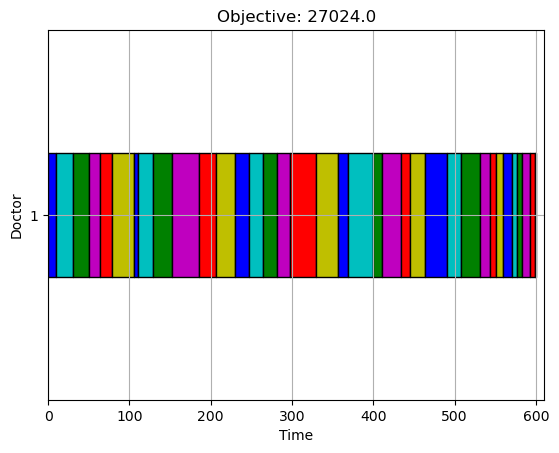

In [30]:
run_reoptimization(choosePatientEA2,"instance6.txt")